In [1]:
import os, sys

# find repo root (looks for liars_poker/ or pyproject.toml)
def find_repo_root(start_dir: str) -> str:
    cur = os.path.abspath(start_dir)
    for _ in range(6):
        if os.path.isdir(os.path.join(cur, "liars_poker")) or os.path.exists(os.path.join(cur, "pyproject.toml")):
            return cur
        parent = os.path.dirname(cur)
        if parent == cur:
            break
        cur = parent
    return os.path.abspath(os.path.join(start_dir, "..", ".."))

NB_DIR = os.getcwd()
REPO_ROOT = find_repo_root(NB_DIR)
if REPO_ROOT not in sys.path:
    sys.path.insert(0, REPO_ROOT)

ARTIFACTS_ROOT = os.path.join(REPO_ROOT, "artifacts")
os.makedirs(ARTIFACTS_ROOT, exist_ok=True)

print("repo root   :", REPO_ROOT)
print("artifacts   :", ARTIFACTS_ROOT)


repo root   : c:\Users\adidh\Documents\liars_poker
artifacts   : c:\Users\adidh\Documents\liars_poker\artifacts


In [2]:
from liars_poker import (
    GameSpec, Env, InfoSet, Rules,
    Policy, TabularPolicy, CommitOnceMixture, RandomPolicy,
    eval_both_seats
)

from liars_poker.training.dense_fsp import dense_fsp_loop
from liars_poker.training.fsp_utils import plot_exploitability_series, save_fsp_run, dense_fsp_resume, faster_eta_control

from liars_poker.algo.br_exact import best_response_exact
from liars_poker.algo.br_mc import best_response_mc

from liars_poker.algo.br_exact_dense_to_dense import best_response_exact as best_response_denser


from liars_poker.policies.tabular_dense import DenseTabularPolicy
from liars_poker.serialization import save_policy

In [3]:
all_specs = [
    GameSpec(ranks=2, suits=2, hand_size=1, claim_kinds=("RankHigh",), suit_symmetry=True), # done
    GameSpec(ranks=2, suits=2, hand_size=1, claim_kinds=("RankHigh", "Pair"), suit_symmetry=True), # done
    GameSpec(ranks=2, suits=3, hand_size=2, claim_kinds=("RankHigh", "Pair"), suit_symmetry=True), # done
    GameSpec(ranks=2, suits=4, hand_size=2, claim_kinds=("RankHigh", "Pair"), suit_symmetry=True), # done
    GameSpec(ranks=2, suits=4, hand_size=2, claim_kinds=("RankHigh", "Pair", "Trips"), suit_symmetry=True), # done

    GameSpec(ranks=3, suits=2, hand_size=1, claim_kinds=("RankHigh",), suit_symmetry=True), # done
    GameSpec(ranks=3, suits=2, hand_size=1, claim_kinds=("RankHigh", "Pair"), suit_symmetry=True), # done
    GameSpec(ranks=3, suits=3, hand_size=2, claim_kinds=("RankHigh", "Pair"), suit_symmetry=True), # done
    GameSpec(ranks=3, suits=4, hand_size=2, claim_kinds=("RankHigh", "Pair"), suit_symmetry=True), # done
    GameSpec(ranks=3, suits=4, hand_size=2, claim_kinds=("RankHigh", "Pair", "Trips"), suit_symmetry=True), #done

    GameSpec(ranks=4, suits=2, hand_size=1, claim_kinds=("RankHigh",), suit_symmetry=True), #done
    GameSpec(ranks=4, suits=2, hand_size=1, claim_kinds=("RankHigh", "Pair"), suit_symmetry=True), #done
    GameSpec(ranks=4, suits=3, hand_size=2, claim_kinds=("RankHigh", "Pair"), suit_symmetry=True), #done
    GameSpec(ranks=4, suits=4, hand_size=2, claim_kinds=("RankHigh", "Pair"), suit_symmetry=True), #done
    GameSpec(ranks=4, suits=4, hand_size=2, claim_kinds=("RankHigh", "Pair", "Trips"), suit_symmetry=True),#done

    GameSpec(ranks=5, suits=2, hand_size=1, claim_kinds=("RankHigh",), suit_symmetry=True), #done
    GameSpec(ranks=5, suits=2, hand_size=1, claim_kinds=("RankHigh", "Pair"), suit_symmetry=True), #done
    GameSpec(ranks=5, suits=3, hand_size=2, claim_kinds=("RankHigh", "Pair"), suit_symmetry=True), #done
    GameSpec(ranks=5, suits=4, hand_size=2, claim_kinds=("RankHigh", "Pair"), suit_symmetry=True), #done
    GameSpec(ranks=5, suits=4, hand_size=2, claim_kinds=("RankHigh", "Pair", "Trips"), suit_symmetry=True), #done

    GameSpec(ranks=6, suits=2, hand_size=1, claim_kinds=("RankHigh",), suit_symmetry=True), #done
    GameSpec(ranks=6, suits=2, hand_size=1, claim_kinds=("RankHigh", "Pair"), suit_symmetry=True), #done
    GameSpec(ranks=6, suits=3, hand_size=2, claim_kinds=("RankHigh", "Pair"), suit_symmetry=True), #done
    GameSpec(ranks=6, suits=4, hand_size=2, claim_kinds=("RankHigh", "Pair"), suit_symmetry=True), # done


    GameSpec(ranks=7, suits=2, hand_size=1, claim_kinds=("RankHigh",), suit_symmetry=True), #done
    GameSpec(ranks=7, suits=2, hand_size=1, claim_kinds=("RankHigh", "Pair"), suit_symmetry=True), #done
    GameSpec(ranks=7, suits=3, hand_size=2, claim_kinds=("RankHigh", "Pair"), suit_symmetry=True), #done
    GameSpec(ranks=7, suits=4, hand_size=2, claim_kinds=("RankHigh", "Pair"), suit_symmetry=True), #done

    GameSpec(ranks=6, suits=4, hand_size=2, claim_kinds=("RankHigh", "Pair", "Trips"), suit_symmetry=True), #cookin?


]
len(all_specs)

29

In [4]:
def powerlaw_eta_control(episodes: int) -> float:
    beta = 0.9  # in (0.5, 1) is a common sweet spot
    return 1 / ((episodes + 2) ** beta)

def even_faster_eta_control(episodes: int) -> float:
    return 10 / (episodes + 20)

def mid_eta_control(episodes: int) -> float:
    return 4 / (episodes + 8)

In [3]:
from datetime import datetime

time_right_now_string = datetime.now().strftime("%Y%m%d-%H%M%S")
# spec = all_specs[27]
spec = GameSpec(ranks=4, suits=4, hand_size=3, claim_kinds=("RankHigh", "Pair", "Trips"), suit_symmetry=True)

episodes = 1000

# pol1, info1 = dense_fsp_loop(spec=spec, episodes=episodes, episodes_test=0, efficient=True)
# pol2, info2 = dense_fsp_loop(spec=spec, episodes=episodes, episodes_test=0, efficient=True, eta_control=faster_eta_control)
# pol3, info3 = dense_fsp_loop(spec=spec, episodes=episodes, episodes_test=0, efficient=True, eta_control=powerlaw_eta_control)
# pol4, info4 = dense_fsp_loop(spec=spec, episodes=episodes, episodes_test=0, efficient=True, eta_control=even_faster_eta_control)
# pol5, info5 = dense_fsp_loop(spec=spec, episodes=episodes, episodes_test=0, efficient=True, eta_control=mid_eta_control)



# short_form = spec.to_short_str() + '___'
# short_form += time_right_now_string
# save_fsp_run(run_id=short_form, policy=pol, info=info, spec=spec)


In [14]:
spec = GameSpec(ranks=5, suits=4, hand_size=4, claim_kinds=("RankHigh", "Pair", "Trips"), suit_symmetry=True)
# pol, info = dense_fsp_loop(spec=spec, episodes=100, episodes_test=0, efficient=True)
# 95s before


In [15]:
import cProfile, pstats, io
from liars_poker.algo.br_exact_dense_to_dense import best_response_dense

pr = cProfile.Profile()
pr.enable()

In [16]:

# run ONE iteration worth of work (or call best_response_dense once)
b_i, meta = best_response_dense(spec=spec, policy=DenseTabularPolicy(spec), debug=False, store_state_values=False)
pr.disable()

s = io.StringIO()
pstats.Stats(pr, stream=s).strip_dirs().sort_stats("cumtime").print_stats(30)
print(s.getvalue())


         2860557 function calls (2794830 primitive calls) in 17.144 seconds

   Ordered by: cumulative time
   List reduced from 504 to 30 due to restriction <30>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
    25/12    0.000    0.000   16.859    1.405 events.py:92(_run)
        1    0.000    0.000   16.855   16.855 kernelbase.py:590(shell_main)
        1    0.000    0.000   16.855   16.855 kernelbase.py:391(dispatch_shell)
        1    0.000    0.000   16.853   16.853 ipkernel.py:364(execute_request)
        1    0.000    0.000   16.853   16.853 kernelbase.py:779(execute_request)
        1    0.000    0.000   16.853   16.853 ipkernel.py:368(do_execute)
        1    0.000    0.000   16.851   16.851 zmqshell.py:660(run_cell)
        1    0.000    0.000   16.851   16.851 interactiveshell.py:3084(run_cell)
        1    0.000    0.000   16.851   16.851 interactiveshell.py:3132(_run_cell)
        1    0.000    0.000   16.849   16.849 async_helpers.py:119(_pseudo

In [10]:
pstats.Stats(pr, stream=s).strip_dirs().sort_stats("cumtime").print_stats(500)

In [2]:
import numpy as np
def powerlaw_eta_control(episodes: int) -> float:
    beta = (1-(0.1/np.log(episodes)))  # in (0.5, 1) is a common sweet spot
    return min(0.5,1 / ((episodes + 2) ** beta))

for i in range(1000):
    print(powerlaw_eta_control(i))

# pol5, info5 = dense_fsp_loop(spec=spec, episodes=episodes, episodes_test=0, efficient=True, eta_control=powerlaw_eta_control)

0.5
0.5
0.30535068954004246
0.23155437302352366
0.18966207476554062
0.16121700675013273
0.14038232305138015
0.12439297510040977
0.11170942971091116
0.10139187128646737
0.09282971133507943
0.08560747618665325
0.07943200947984382
0.07409026656607742
0.0694235655252263
0.06531121886214503
0.06165976715156349
0.05839568947321969
0.055460343238399976
0.05280637427994427
0.05039512063467856
0.04819470260741499
0.04617859602065881
0.044324551582948214
0.042613766086091846
0.0410302394393306
0.0395602706238531
0.03819205873181266
0.036915384365324745
0.03572135310911247
0.03460218740031432
0.033551056460277964
0.03256193640262271
0.0316294944465486
0.030748992522089437
0.029916206579216998
0.029127358693541137
0.028379059660905502
0.027668260237061083
0.02699220954010405
0.026348419417004672
0.025734633799537863
0.02514880225288203
0.024589057062359115
0.024053693318054636
0.023541151549352494
0.023050002536342824
0.02257893398617146
0.02212673881247102
0.021692304797218454
0.02127460544841292

C:\Users\adidh\AppData\Local\Temp\ipykernel_21692\3127179582.py:3: RuntimeWarning: divide by zero encountered in log
  beta = (1-(0.1/np.log(episodes)))  # in (0.5, 1) is a common sweet spot
C:\Users\adidh\AppData\Local\Temp\ipykernel_21692\3127179582.py:3: RuntimeWarning: divide by zero encountered in scalar divide
  beta = (1-(0.1/np.log(episodes)))  # in (0.5, 1) is a common sweet spot
C:\Users\adidh\AppData\Local\Temp\ipykernel_21692\3127179582.py:4: RuntimeWarning: divide by zero encountered in scalar divide
  return min(0.5,1 / ((episodes + 2) ** beta))


In [66]:
import numpy as np
def powerlaw_eta_control(episodes: int) -> float:
    beta = (1-(0.2/np.log(episodes)))  # in (0.5, 1) is a common sweet spot
    return min(0.5,1 / ((episodes + 2) ** beta))

for i in range(1000):
    print(powerlaw_eta_control(i))

pol6, info6 = dense_fsp_loop(spec=spec, episodes=episodes, episodes_test=0, efficient=True, eta_control=powerlaw_eta_control)

C:\Users\adidh\AppData\Local\Temp\ipykernel_36236\942310401.py:3: RuntimeWarning: divide by zero encountered in log
  beta = (1-(0.2/np.log(episodes)))  # in (0.5, 1) is a common sweet spot
C:\Users\adidh\AppData\Local\Temp\ipykernel_36236\942310401.py:3: RuntimeWarning: divide by zero encountered in scalar divide
  beta = (1-(0.2/np.log(episodes)))  # in (0.5, 1) is a common sweet spot
C:\Users\adidh\AppData\Local\Temp\ipykernel_36236\942310401.py:4: RuntimeWarning: divide by zero encountered in scalar divide
  return min(0.5,1 / ((episodes + 2) ** beta))


0.5
0.5
0.37295617441031764
0.2680871383315857
0.21583021562621715
0.1819364628583064
0.15765757300241648
0.1392625102889805
0.12478996686337003
0.11308342719268727
0.10340826367865007
0.09527231972762926
0.088332217820084
0.08234051399748615
0.07711410320376626
0.07251444025740315
0.06843468393333052
0.06479107443200131
0.061516993442422764
0.05855877645646476
0.055872700043243725
0.05342277526659498
0.051179105530540926
0.04911664682573595
0.04721425956104392
0.04545397480811761
0.04382042033130984
0.0423003671550526
0.040882368085189885
0.03955646710632289
0.03831396393236708
0.03714722185682506
0.03604950987780716
0.0350148721630487
0.03403801948044645
0.03311423839534429
0.03223931492956384
0.03140947006225212
0.030621304981829415
0.02987175441013226
0.029158046642524322
0.028477669202241606
0.027828339209200827
0.02720797772471787
0.026614687462995185
0.026046733364670317
0.025502525612419717
0.024980604737642527
0.024479628523765572
0.02399836045818678
0.023535659523253313
0.023

In [1]:
from typing import Dict, Iterable, Tuple
def plot_exploitability_series(logs: Dict | Iterable[Dict], *, figsize: tuple[int, int] = (12, 6)):
    """Plot exploitability over iterations using the logs dict returned by fsp_loop/dense_fsp_loop."""
    import matplotlib.pyplot as plt

    series_list = logs if isinstance(logs, Iterable) and not isinstance(logs, Dict) else [logs]

    fig, ax = plt.subplots(figsize=figsize)
    for idx, entry in enumerate(series_list, start=1):
        series = entry.get("exploitability_series", [])
        if not series:
            continue
        vals = [
            (2*pt.get("predicted_avg", pt.get("rollout_avg", 0.0)))-1
            for pt in series
        ]
        ax.scatter(range(1, len(vals) + 1), vals, marker="o", label=f"run {idx}", s=0.1)

    ax.set_xlabel("Episode")
    ax.set_ylabel("Exploitability")
    ax.set_title("Exploitability over FSP iterations")
    ax.grid(True, alpha=0.3)
    if ax.lines:
        ax.legend()
    fig.tight_layout()
    plt.xscale('log')
    plt.yscale('log')
    # plt.xlim((900,1000))
    # plt.ylim(0,0.1)
    return ax


plot_exploitability_series([info1, info2, info3, info4, info5, info6])

NameError: name 'info1' is not defined

<Axes: title={'center': 'Exploitability over FSP iterations'}, xlabel='Episode', ylabel='Exploitability'>

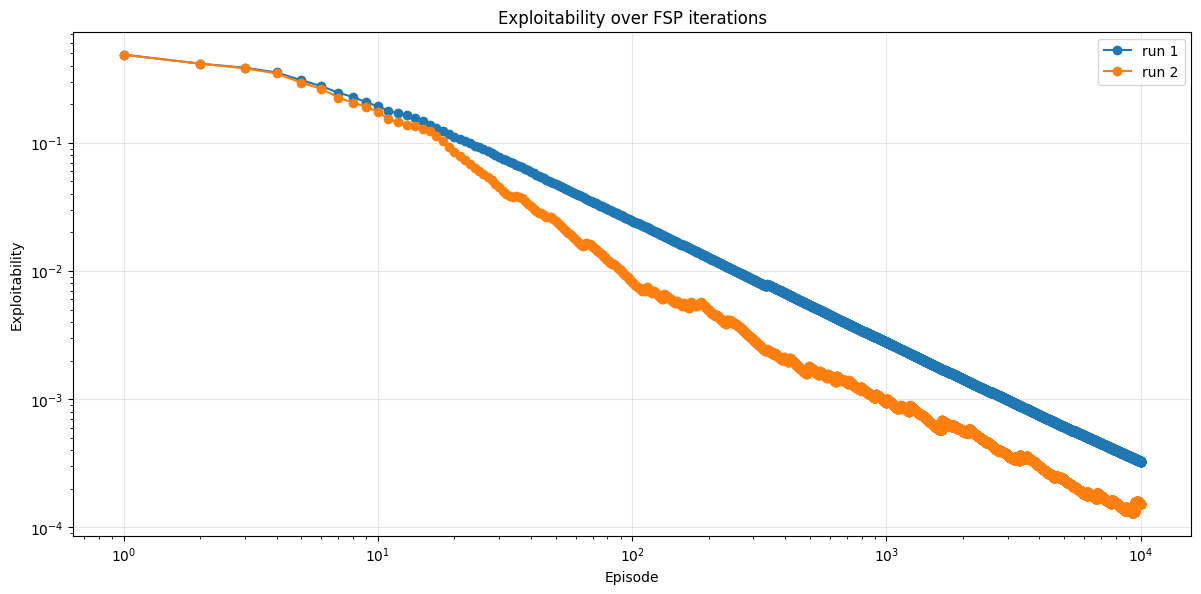

In [23]:
plot_exploitability_series([info1, info2])

<Axes: title={'center': 'Exploitability over FSP iterations'}, xlabel='Episode', ylabel='Exploitability'>

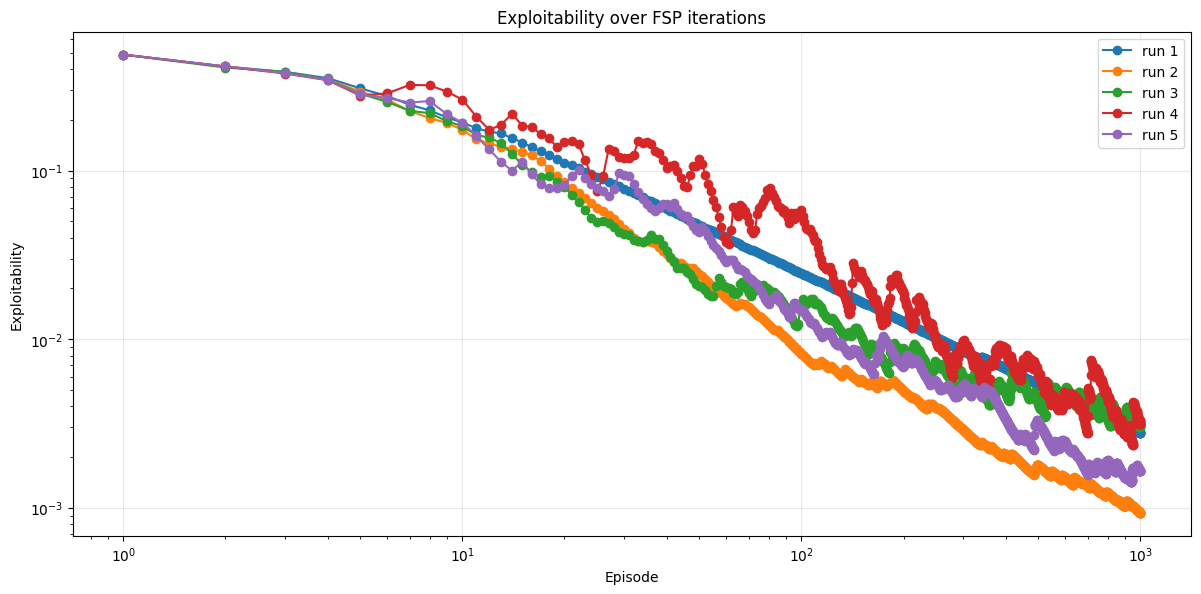

In [21]:
plot_exploitability_series([info1, info2, info3, info4, info5])

In [ ]:
# Trendline helper for dense_fsp_loop logs
import math
import numpy as np

def plot_with_trend(info, *, last_n=None, targets=(1e-2, 2e-3)):
    series = info.get("exploitability_series", [])
    if not series:
        print("No exploitability data.")
        return None

    # Use predicted_avg when available, else rollout_avg
    y_vals = []
    for pt in series:
        y = pt.get("predicted_avg")
        if y is None:
            y = pt.get("rollout_avg", 0.0)
        y_vals.append(2*float(y)-1)

    n = len(y_vals)
    x_vals = np.arange(1, n + 1, dtype=float)

    if last_n is None:
        last_n = max(5, n - 50)
    last_n = min(max(2, int(last_n)), n)

    x_fit = x_vals[-last_n:]
    y_fit = np.array(y_vals[-last_n:], dtype=float)
    mask = y_fit > 0
    if mask.sum() < 2:
        print("Not enough positive points to fit a trendline.")
        plot_exploitability_series(info)
        return None

    logx = np.log10(x_fit[mask])
    logy = np.log10(y_fit[mask])
    slope, intercept = np.polyfit(logx, logy, 1)

    ax = plot_exploitability_series(info)
    if ax is None:
        return None
    y_pred = 10 ** (intercept + slope * np.log10(x_vals))
    ax.plot(x_vals, y_pred, linestyle='--', color='black', alpha=0.7, label='trend (power law)')
    ax.legend()

    print(f"Fit (log10): y = 10^( {intercept:.4f} + {slope:.4f} * log10(x) )")

    for target in targets:
        if target <= 0:
            continue
        # Solve for x: log10(y) = intercept + slope * log10(x)
        # log10(x) = (log10(target) - intercept) / slope
        if slope == 0:
            print(f"Target {target:.4g}: slope is 0, no crossing predicted.")
            continue
        logx_star = (math.log10(target) - intercept) / slope
        x_star = 10 ** logx_star
        print(f"Target {target:.4g}: predicted at step ~{x_star:.1f}")

    return ax


Fit (log10): y = 10^( 0.1618 + -0.4442 * log10(x) )
Target 0.01: predicted at step ~73614.8
Target 0.002: predicted at step ~2757754.3


<Axes: title={'center': 'Exploitability over FSP iterations'}, xlabel='Episode', ylabel='Exploitability'>

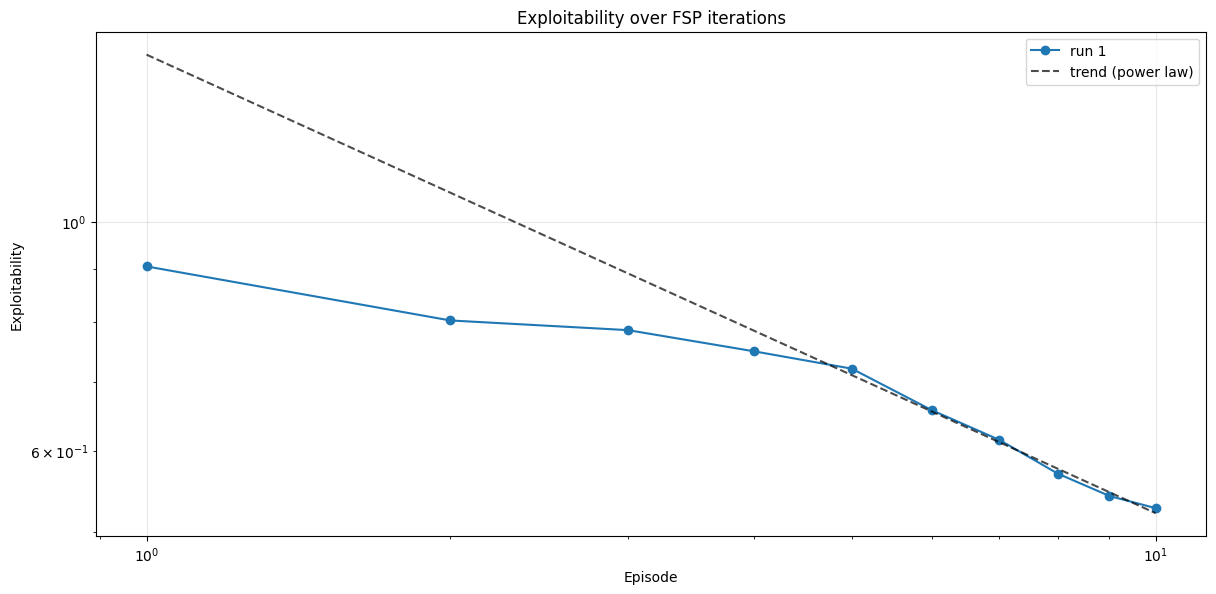

In [ ]:
import json
info = json.loads('C:\Users\adidh\Documents\liars_poker\artifacts\benchmark_runs\r5_s4_h2_hpt_ss___20260102-160842\metrics.json')
plot_with_trend(info)